<a href="https://colab.research.google.com/github/lizhieffe/llm_knowledge/blob/main/%5BTriton%5D_%5BCanonical%5D_1_Vector_Addition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instruction: https://triton-lang.org/main/getting-started/tutorials/01-vector-add.html

In [1]:
!uv pip install -U --index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/Triton-Nightly/pypi/simple/ triton-nightly

Using Python 3.11.13 environment at: /usr
Resolved 2 packages in 1.45s
Audited 2 packages in 0.17ms


In [2]:
import torch

import triton
import triton.language as tl

In [4]:
# The command doesn't work: https://github.com/triton-lang/triton/issues/5388
# DEVICE = triton.runtime.driver.active.get_active_torch_device()

DEVICE = torch.device("cuda:0")

In [14]:
# @title Triton fn

@triton.jit
def add_kernel(
    x_ptr,
    y_ptr,
    output_ptr,
    n_elements, # total elements in x or y to apply element-wise addition
    BLOCK_SIZE: tl.constexpr,
):
  pid = tl.program_id(axis=0)
  # print(f"{pid=}")

  block_start = pid * BLOCK_SIZE
  offsets = block_start + tl.arange(0, BLOCK_SIZE)
  mask = tl.where(offsets < n_elements, True, False)

  x = tl.load(x_ptr + offsets, mask, 0)
  y = tl.load(y_ptr + offsets, mask, 0)

  ret = x + y

  tl.store(output_ptr + offsets, ret, mask=mask)

In [15]:
def add(x: torch.Tensor, y: torch.Tensor):
  output = torch.empty_like(x)
  assert x.device == DEVICE and y.device == DEVICE and output.device == DEVICE
  n_elements = output.shape[0]
  grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )
  add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)
  return output

In [22]:
torch.manual_seed(0)
size = 98432
x = torch.rand(size, device=DEVICE)
y = torch.rand(size, device=DEVICE)
output_cpu = x + y
output_triton = add(x, y)
# print(f"{output_triton=}")
assert torch.allclose(output_cpu, output_triton)

In [20]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 28, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='vector-add-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    x = torch.rand(size, device=DEVICE, dtype=torch.float32)
    y = torch.rand(size, device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

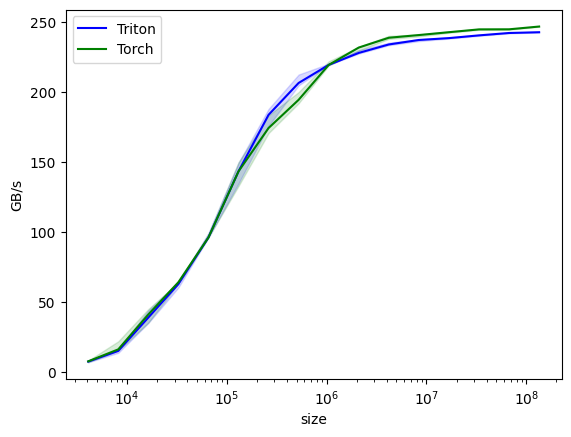

vector-add-performance:
           size      Triton       Torch
0        4096.0    7.245283    7.438257
1        8192.0   14.912622   15.999999
2       16384.0   38.763407   40.959998
3       32768.0   62.693880   63.999998
4       65536.0   96.000000   96.000000
5      131072.0  143.300295  143.300295
6      262144.0  183.745795  174.297876
7      524288.0  206.521014  194.468840
8     1048576.0  219.428568  219.428568
9     2097152.0  228.017399  231.849058
10    4194304.0  234.057145  238.855578
11    8388608.0  237.270178  240.793635
12   16777216.0  238.601945  242.828986
13   33554432.0  240.558861  244.841842
14   67108864.0  242.260945  244.891884
15  134217728.0  242.799696  246.876239


In [21]:
benchmark.run(print_data=True, show_plots=True)
